In [1]:
import pickle

import json
from pandas.io.json import json_normalize

import pandas as pd
import numpy as np
import datetime

from collections import defaultdict
from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.options.display.max_columns = 80

In [2]:
with open('google_full.pkl', 'rb') as f:
    df = pickle.load(f)

# Unnest Json columns

In [3]:
json_col = ["totals", "trafficSource", "device", "geoNetwork"]

for meta_col in json_col:
    temp_df = json_normalize(data=df[meta_col])
    temp_col = temp_df.columns
    temp_df.columns = [ meta_col + "." + x for x in temp_col]
    df=df.join(temp_df, lsuffix='_')

df = df.drop(columns = json_col)

## Clean columns containing only null or only one value throughout

In [4]:
# clean columns that contains same value for all observations
total_observations = len(df)
list_to_delete = []
for col in df.columns:
    i = df[col].nunique()
    if ( (i == 0) | ((i == 1) & (df[col].count()==total_observations ))):
        list_to_delete.append(col)
df = df.drop(columns=list_to_delete)

# remove total.sessionQualityDim since it only covers one month period from 070417 to 080117
df = df.drop(columns=["totals.sessionQualityDim", "trafficSource.campaignCode"])

In [5]:
# # check different values in each columns
# check_col = []
# for col in df.columns:
#     if df[col].count() < 0.5*total_observations:
#         check_col.append(col)
#         print("{}\t unique values out of {} values in <{}>".format(df[col].nunique(), df[col].count(), col))

# Feature engineering on continuous data

## Dependent for this project: purchased_or_not

In [6]:
# based on revenue, create purchased or not column
df["purchased_or_not"] = 0
mask1 = "totals.totalTransactionRevenue"
mask2 = "purchased_or_not"
df.loc[ ~df[mask1].isnull() , mask2] = 1

df= df.drop(columns = ["totals.totalTransactionRevenue",\
                       "totals.transactionRevenue", "totals.transactions"])

## Clean null and add "bot_traffic" feature

In [7]:
continuous_col = ["totals.hits", "totals.pageviews", "totals.timeOnSite", "visitNumber"]
for col in continuous_col:
    df[col] = df[col].fillna(0)

# create "bot_traffic" feature that identifies bot spend less than 3 seconds on each webpage
df[ "bot_traffic"] = 0
df.loc[ (df["totals.pageviews"] >= 0.35 * df["totals.timeOnSite"]), "bot_traffic" ] = 1.0

## log(x+1) transformation on continuous features

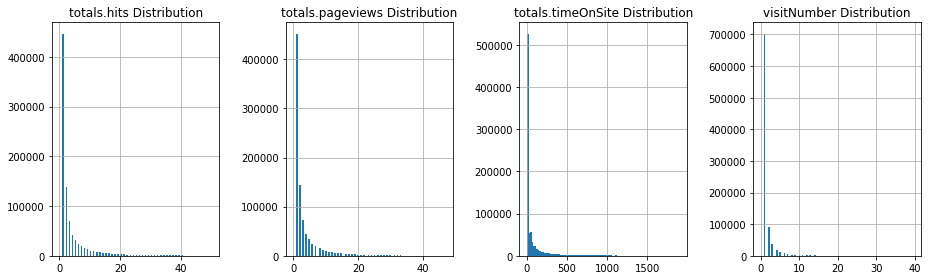

In [8]:
continuous_col = ["totals.hits", "totals.pageviews", "totals.timeOnSite", "visitNumber"]

# some features are distributed over a large range, they need to be log transformed
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(13, 4))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins = 100, ax=ax, range=(0, 0.1*df[var_name].max()))
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

test = df[continuous_col]
draw_histograms(test, test.columns, 1, len(test.columns))

In [9]:
# log(x+1) transformation
for col in continuous_col:
    df["log_"+ col.split(".")[-1] ] = np.log(df[col] + 1)

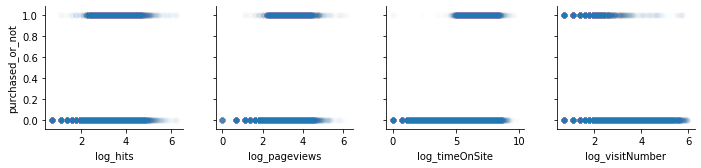

In [10]:
# under log(x+1) transform the four continuous variables all separates purchased visitor, i.e. in log_timeOnSite, 
# any visitors have to spent at least 1 minutes(e^4 seconds) on website before making a purchase.
pp = sns.pairplot(data=df, y_vars=["purchased_or_not"], \
                  x_vars= ["log_"+ col.split(".")[-1] for col in continuous_col], plot_kws=dict(alpha=0.01))

In [90]:
# with open('google_cleaned.pkl', 'wb') as f:
#     pickle.dump(df, f)

with open('google_cleaned.pkl', 'rb') as f:
    df = pickle.load(f)

# Feature engineering on discrete data

## Features: hour and day_of_week

In [92]:
# produce the hour and weekday column

df["datetime"] = pd.to_datetime(df.visitStartTime, unit='s')
df["hour"] = df.datetime.apply(lambda x: x.hour)
week_day= ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
df["dayofweek"] = df.datetime.apply(lambda x: week_day[ x.weekday()] )

# Automated feature engineering: grouping categorical data by higer or lower purchase rate

In this dataset, most of the discrete features contains too many categorical values, i.e. there are about 200 countries for geo-location, and even more cities, seting them all as dummy indices will result in too many features. Moreover, some column might be important but hard for human to understand and hand select, such as referral path. In this section I wrote an automated algorithm to group the categorical values that significantly increase or decrease the purchase rate, and based on that, engineer features. 

In [93]:
# purchase rate over the entire dataset is:
print("purchase rate over the entire data set is: ", df[df.purchased_or_not == 1].shape[0] / df.shape[0])

purchase rate over the entire data set is:  0.0127427231470487


In [94]:
feature_selection_columns = [
'channelGrouping',
'totals.newVisits',
'trafficSource.adContent',
'trafficSource.adwordsClickInfo.adNetworkType',
'trafficSource.adwordsClickInfo.gclId',
'trafficSource.adwordsClickInfo.isVideoAd',
'trafficSource.adwordsClickInfo.page',
'trafficSource.adwordsClickInfo.slot',
'trafficSource.campaign',
'trafficSource.isTrueDirect',
'trafficSource.keyword',
'trafficSource.medium',
'trafficSource.referralPath',
'trafficSource.source',
'device.browser',
'device.deviceCategory',
'device.isMobile',
'device.operatingSystem',
'geoNetwork.city',
'geoNetwork.continent',
'geoNetwork.country',
'geoNetwork.metro',
'geoNetwork.networkDomain',
'geoNetwork.region',
'geoNetwork.subContinent',
'hour',
'dayofweek']

In [62]:
# Automated feature engineering algorithm

high_purchase_rate = 0.024
low_purchase_rate = 0.0005
count_threshold = 50000
sub_category_threshold = 500

high_purchase_rate_feat = defaultdict(list)
low_purchase_rate_feat = defaultdict(list)

for col in feature_selection_columns:
    print("working on <{}> column".format(col))
    high_count = 0
    low_count = 0
    s = df[col].value_counts()
    
    for val in s[s>sub_category_threshold].index:
        pur = df[ df[col]==val ].purchased_or_not.value_counts()
        try:
            rate=pur[1]/s[val]
        except KeyError:
            rate=0  
        if rate > high_purchase_rate: 
            high_purchase_rate_feat[col].append(val)
            high_count += s[val] 
        if rate < low_purchase_rate:
            low_purchase_rate_feat[col].append(val)
            low_count += s[val]
                            
    high_purchase_rate_feat[col].append(high_count)
    low_purchase_rate_feat[col].append(low_count)
    
    if high_count < count_threshold:
        try:
            del high_purchase_rate_feat[col]
        except KeyError:
            continue
    if low_count < count_threshold:
        try:
            del low_purchase_rate_feat[col]
        except KeyError:
            continue
print("Job done!")

In [60]:
# categorical values in each columns that correlate to a higher purchase rate

print(len(high_purchase_rate_feat.keys()), "features found", end="\n\n")
for key in high_purchase_rate_feat.keys():
    print(key, high_purchase_rate_feat[key], end="\n\n")

11 features found

channelGrouping ['Referral', 104838]

trafficSource.isTrueDirect [True, 274005]

trafficSource.referralPath ['/', '/mail/u/0/', '/a/google.com/forum/', 77307]

device.operatingSystem ['Macintosh', 'Chrome OS', 280275]

geoNetwork.city ['Mountain View', 'New York', 'San Francisco', 'Sunnyvale', 'Los Angeles', 'Chicago', 'Seattle', 'Austin', 'Santa Clara', 'Washington', 'Atlanta', 'Ann Arbor', 'Salem', 'Kirkland', 'San Bruno', 'Cambridge', 'San Diego', 'Pittsburgh', 'Irvine', 'Cupertino', 147412]

geoNetwork.continent ['Americas', 450377]

geoNetwork.country ['United States', 'Venezuela', 366876]

geoNetwork.metro ['San Francisco-Oakland-San Jose CA', 'New York NY', 'Los Angeles CA', 'Seattle-Tacoma WA', 'Chicago IL', 'Austin TX', 'Washington DC (Hagerstown MD)', 'Boston MA-Manchester NH', 'Atlanta GA', 'Detroit MI', 'Roanoke-Lynchburg VA', 'San Diego CA', 'Pittsburgh PA', 'Denver CO', 'Phoenix AZ', 'Charlotte NC', 169322]

geoNetwork.networkDomain ['(not set)', 'comca

In [61]:
# categorical values that correlate to lower purchase rate

print(len(low_purchase_rate_feat.keys()), "features found", end="\n\n")
for key in low_purchase_rate_feat.keys():
    print(key, low_purchase_rate_feat[key], end="\n\n")

9 features found

channelGrouping ['Social', 226117]

trafficSource.referralPath ['/yt/about/', '/analytics/web/', '/yt/about/tr/', '/yt/about/vi/', '/yt/about/es-419/', '/yt/about/pt-BR/', '/yt/about/th/', '/yt/about/ru/', '/yt/about/es/', '/yt/about/en-GB/', '/yt/about/fr/', '/yt/about/ja/', '/yt/about/ar/', '/yt/about/pl/', '/yt/about/de/', '/yt/about/zh-TW/', '/yt/about/ro/', '/yt/about/ko/', '/yt/about/it/', '/yt/about/id/', '/YKEI_mrn/items/c10b14f9a69ff71b1b7a', '/analytics/web/inpage_launch', '/yt/about/iw/', '/yt/about/zh-CN/', '/r/golang/comments/4spnk9/where_to_buy_the_golang_gopher_plush/', '/mobile', '/gopher', '/yt/about/nl/', '/yt/about/bg/', '/yt/about/hu/', '/yt/about/cs/', '/yt/about/el/', '/yt/about/sr/', '/How-can-one-get-a-Google-T-shirt-in-India', 219475]

trafficSource.source ['youtube.com', 'analytics.google.com', 'baidu', 'reddit.com', 'qiita.com', 'blog.golang.org', 236707]

geoNetwork.city ['Bangkok', 'Ho Chi Minh City', 'Istanbul', 'Bengaluru', 'Hanoi', 'Mum

## Create new categorical features

In [95]:
for key in high_purchase_rate_feat:
    df["high_"+key] = 0
for key in low_purchase_rate_feat:
    df["low_"+ key] = 0
    
for key in high_purchase_rate_feat:
    for val in high_purchase_rate_feat[key][:-1]:
        df.loc[df[key] == val, "high_"+key ]  = 1        
for key in low_purchase_rate_feat:
    for val in low_purchase_rate_feat[key][:-1]:
        df.loc[df[key] == val, "low_"+key ]  = 1

In [97]:
# # print out column names
# for col in df.columns:
#     print("\"{}\",".format(col))

## Eliminate multicollinearity

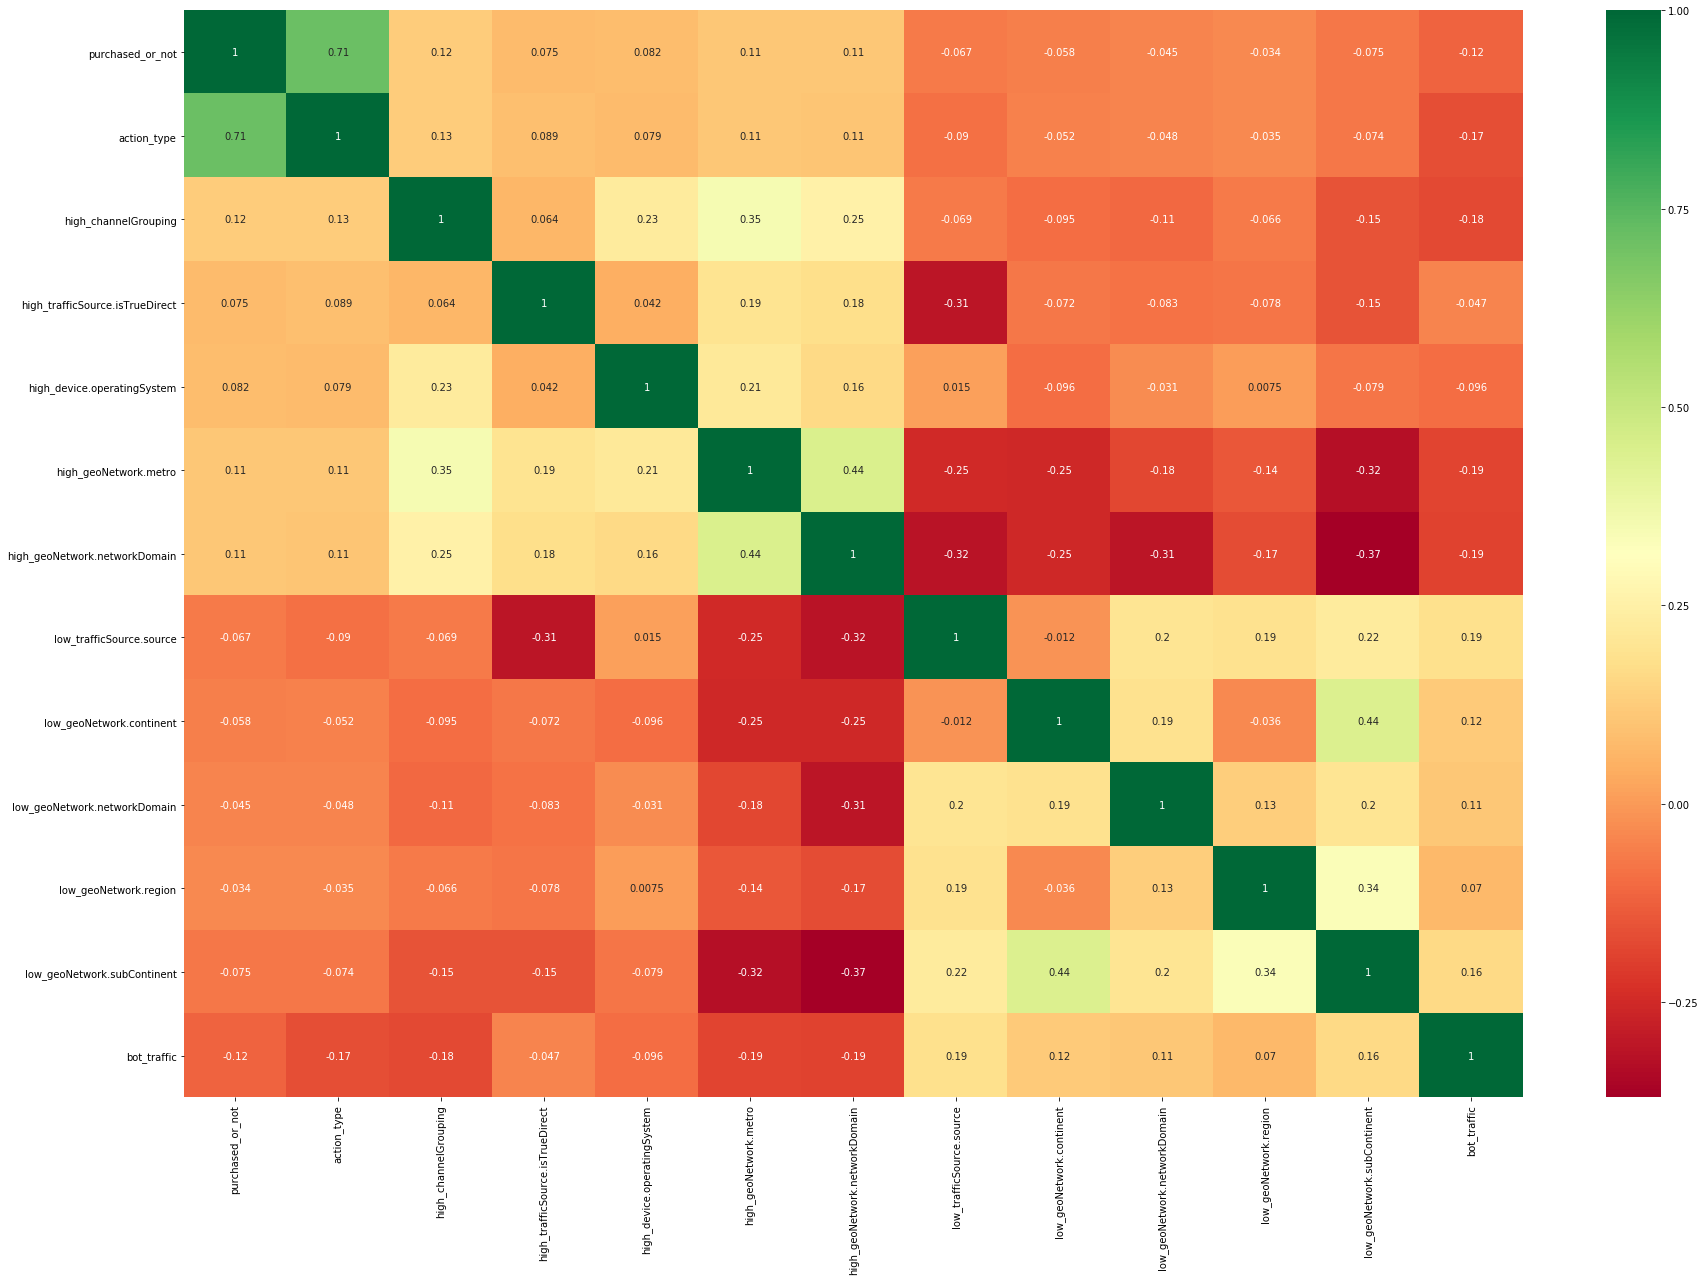

In [98]:
# use the correlation heatmap to reduce the colinear features, remove the highly correlated features(correlation > 0.6)

plt.figure(figsize=(30, 20))
g=sns.heatmap(df[[
"purchased_or_not",
"action_type",
"high_channelGrouping",
"high_trafficSource.isTrueDirect",
# "high_trafficSource.referralPath",
"high_device.operatingSystem",
# "high_geoNetwork.city",
# "high_geoNetwork.continent",
# "high_geoNetwork.country",
"high_geoNetwork.metro",
"high_geoNetwork.networkDomain",
# "high_geoNetwork.region",
# "high_geoNetwork.subContinent",
# "low_channelGrouping",
# "low_trafficSource.referralPath",
"low_trafficSource.source",
# "low_geoNetwork.city",
"low_geoNetwork.continent",
# "low_geoNetwork.country",
"low_geoNetwork.networkDomain",
"low_geoNetwork.region",
"low_geoNetwork.subContinent",
"bot_traffic"
]].corr(),annot=True,cmap="RdYlGn")

# Output cleaned data

In [99]:
df = df[[
"purchased_or_not",
"visitId",
"visitStartTime",
"fullVisitorId",
"ID",
"log_hits",
"log_pageviews",
"log_timeOnSite",
"log_visitNumber",
"totals.newVisits",
"totals.bounces",
"action_type",
"high_channelGrouping",
"high_trafficSource.isTrueDirect",
"high_device.operatingSystem",
"high_geoNetwork.metro",
"high_geoNetwork.networkDomain",
"low_trafficSource.source",
"low_geoNetwork.continent",
"low_geoNetwork.networkDomain",
"low_geoNetwork.region",
"low_geoNetwork.subContinent",
"bot_traffic"
]]
df["totals.newVisits"] = df["totals.newVisits"].fillna(0)
df["totals.bounces"] = df["totals.bounces"].fillna(0)

In [110]:
# with open('google_feature_engineering.pkl', 'wb') as f:
#     pickle.dump(df, f)

with open('google_feature_engineering.pkl', 'rb') as f:
    df = pickle.load(f)